In [1]:
# Bloque 1: Importar bibliotecas necesarias
import glob
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



2025-06-20 16:44:53.773656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-20 16:44:53.773763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-20 16:44:53.854989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-20 16:44:54.088061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-20 16:44:56.497882: W tensorflow/compiler/tf2

In [2]:
# Verificamos que contamos con GPU y Cuda en tensorflow

print(f"Tensorflow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"Cuda version: {tf.test.is_built_with_cuda()}")

Tensorflow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Cuda version: True


2025-06-20 16:45:02.055533: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-20 16:45:02.263185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-20 16:45:02.263759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
# Bloque 2: Cargar y concatenar todos los CSV en un único DataFrame
ROOT_PATH = "./datasets"
csv_files = glob.glob(os.path.join(ROOT_PATH, "*.csv"))
# Leer cada CSV y concatenarlos
dataframe = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)



In [19]:
# -------------------------------
# Downsample aleatorio de steering_angle == 0
# -------------------------------
# Asegurar dtype float
dataframe['steering_angle'] = pd.to_numeric(dataframe['steering_angle'], errors='coerce')

# Separar ceros y no-ceros
zero_df     = dataframe[dataframe['steering_angle'].abs() < 1e-4]
non_zero_df = dataframe[dataframe['steering_angle'].abs() >= 1e-4]

print(f"Antes: zeros={len(zero_df)}, non-zeros={len(non_zero_df)}")

# Muestrear sólo un porcentaje de ceros
zero_keep_frac = 0.2  # ajusta esto (0.1 = conservar 10 % de los ceros)
zero_df = zero_df.sample(frac=zero_keep_frac, random_state=42)
print(f" Muestreando {len(zero_df)} ceros ({zero_keep_frac*100:.0f} %)")

# Reconstruir y mezclar
dataframe = pd.concat([non_zero_df, zero_df], axis=0) \
              .sample(frac=1.0, random_state=42)       \
              .reset_index(drop=True)

print(f"Después: zeros={ (dataframe['steering_angle'].abs()<1e-4).sum() }," 
      f" non-zeros={ (dataframe['steering_angle'].abs()>=1e-4).sum() }")

# Vista previa
dataframe.head()

Antes: zeros=4680, non-zeros=4921
 Muestreando 936 ceros (20 %)
Después: zeros=936, non-zeros=4921


,left_image,center_image,right_image,steering_angle,timestamp
0,2025-06-20_00-26-22/2025_06_20_00_31_23_055139...,2025-06-20_00-26-22/2025_06_20_00_31_23_055139...,2025-06-20_00-26-22/2025_06_20_00_31_23_055139...,-0.00,2025_06_20_00_31_23_055139
1,2025-06-19_18-34-48/2025_06_19_18_38_02_119934...,2025-06-19_18-34-48/2025_06_19_18_38_02_119934...,2025-06-19_18-34-48/2025_06_19_18_38_02_119934...,-0.08,2025_06_19_18_38_02_119934
2,2025-06-20_00-46-05/2025_06_20_00_47_37_032977...,2025-06-20_00-46-05/2025_06_20_00_47_37_032977...,2025-06-20_00-46-05/2025_06_20_00_47_37_032977...,0.02,2025_06_20_00_47_37_032977
3,2025-06-19_20-19-47/2025_06_19_20_20_13_533926...,2025-06-19_20-19-47/2025_06_19_20_20_13_533926...,2025-06-19_20-19-47/2025_06_19_20_20_13_533926...,0.06,2025_06_19_20_20_13_533926
4,2025-06-19_18-34-48/2025_06_19_18_40_01_849119...,2025-06-19_18-34-48/2025_06_19_18_40_01_849119...,2025-06-19_18-34-48/2025_06_19_18_40_01_849119...,-0.06,2025_06_19_18_40_01_849119


In [20]:
# Imprimimos el total de imagenes del datasframe de pandas
print(f"Total de imagenes en el dataset: {len(dataframe * 3)}")

Total de imagenes en el dataset: 5857


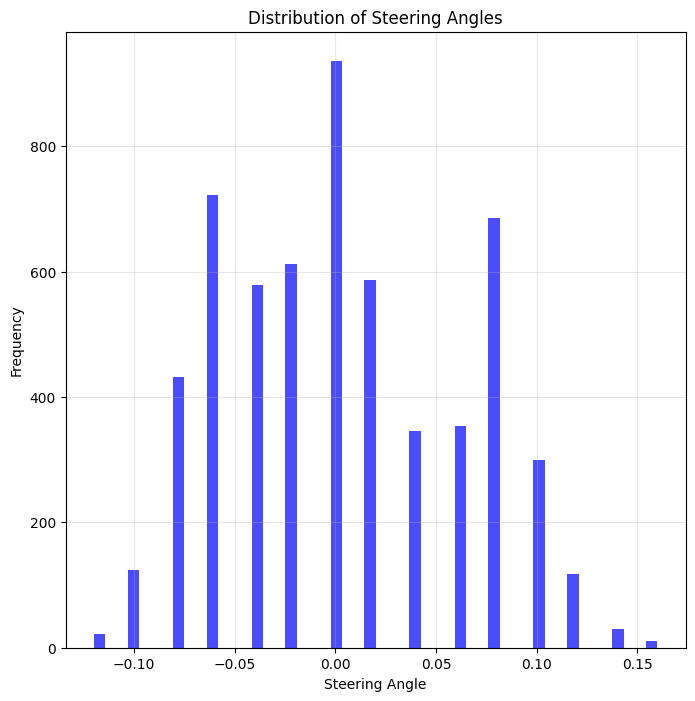

In [21]:
# Mostramos el histograma de los angulos de los datos de entrenamiento en el dataframe
plt.figure(figsize=(8, 8))
plt.hist(dataframe['steering_angle'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Steering Angles')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
# Dataset with optimized loading, caching, and shuffling
def create_tf_dataset(df, batch_size=32, img_height=66, img_width=200, steering_correction=0.02):
    """
    Creates a tf.data.Dataset from a DataFrame with image paths and steering angles.
    Features:
    - Optimized loading with caching
    - Post-cache shuffling for better randomization
    - Data augmentation (flip and shadows)
    - Efficient memory usage
    - Gaussian blur preprocessing
    """
    # Constant tensor for root path
    root = tf.constant(ROOT_PATH)
    
    # Calculate buffer sizes for shuffling
    num_rows = df.shape[0]
    num_images = num_rows * 3  # 3 images per row (center, left, right)
    shuffle_buffer = min(num_images, 10000)  # Limit buffer size for memory efficiency

    # Function to add random shadow
    def add_random_shadow(image):
        shape = tf.shape(image)
        h, w = shape[0], shape[1]
        # Random points for shadow line
        x1, y1 = 0, tf.random.uniform([], 0, h, dtype=tf.int32)
        x2, y2 = w, tf.random.uniform([], 0, h, dtype=tf.int32)
        # Coordinate mesh
        xm, ym = tf.meshgrid(tf.range(w), tf.range(h))
        # Boolean mask for shadow region
        mask = tf.cast((ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0, tf.float32)
        mask = tf.expand_dims(mask, axis=2)
        mask = tf.tile(mask, [1, 1, 3])
        # Random darkness
        shade = tf.random.uniform([], 0.2, 0.7)
        return image * (mask * (1 - shade) + (1 - mask))

    # Augmentation function: flip or shadow
    def augment(image, angle):
        def do_flip():
            flipped = tf.image.flip_left_right(image)
            return flipped, -angle
        def do_shadow():
            return add_random_shadow(image), angle
        return tf.cond(tf.random.uniform([]) < 0.5, do_flip, do_shadow)

    # Function to read and preprocess images
    def load_and_preprocess(center_path, left_path, right_path, steering_angle):
        angle = tf.cast(steering_angle, tf.float32)

        # Build full paths
        center_full = tf.strings.join([root, center_path], separator='/')
        left_full = tf.strings.join([root, left_path], separator='/')
        right_full = tf.strings.join([root, right_path], separator='/')

        # Read and resize function with preprocessing
        def read_and_resize(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img)
            img = tf.image.resize(img, [img_height, img_width])
            # Convert to float32 before blur for better precision
            img = tf.cast(img, tf.float32)
            # Apply Gaussian blur with sigma=0.5 (adjust this value if needed)
            # Normalize to [0,1]
            img = img / 255.0
            return img

        # Load all three images
        c = read_and_resize(center_full)
        l = read_and_resize(left_full)
        r = read_and_resize(right_full)

        # Apply steering corrections
        angles = tf.stack([angle, angle + steering_correction, angle - steering_correction], axis=0)
        images = tf.stack([c, l, r], axis=0)
        return images, angles

    # Create and configure the dataset pipeline
    ds = tf.data.Dataset.from_tensor_slices(
        (df['center_image'], df['left_image'], df['right_image'], df['steering_angle'])
    )
    
    # Build optimized pipeline
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)  # Load images
    ds = ds.cache()                                                        # Cache loaded images
    ds = ds.unbatch()                                                     # Separate examples
    ds = ds.shuffle(shuffle_buffer, reshuffle_each_iteration=True)        # Shuffle after cache
    ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)            # Apply augmentation
    ds = ds.batch(batch_size)                                            # Create batches
    ds = ds.prefetch(tf.data.AUTOTUNE)                                   # Prefetch next batch

    return ds


In [23]:
# Split DataFrame into training and validation sets
train_df, val_df = train_test_split(dataframe, test_size=0.25, random_state=42)

# Calculate dataset sizes for logging
num_train = len(train_df)
num_val = len(val_df)
print(f"Training samples: {num_train * 3} images")  # *3 because of center, left, right cameras
print(f"Validation samples: {num_val * 3} images")

# Create optimized datasets for training and validation
# Training dataset: with full augmentation and shuffling
train_ds = create_tf_dataset(
    df=train_df,
    batch_size=64,
    img_height=66,
    img_width=200,
    steering_correction=0.02
)

# Validation dataset: no augmentation needed
val_ds = create_tf_dataset(
    df=val_df,
    batch_size=64,
    img_height=66,
    img_width=200,
    steering_correction=0.02
)


Training samples: 13176 images
Validation samples: 4395 images


In [32]:
# Create a sequential model
def get_model_nvidia():
    model = tf.keras.Sequential([
            # First convolutional layer, input shape specified
        layers.InputLayer((66, 200, 3)),

        layers.Conv2D(24, kernel_size=5, strides=2, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Second convolutional layer
        layers.Conv2D(36, kernel_size=5, strides=2, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Third convolutional layer
        layers.Conv2D(48, kernel_size=5, strides=2, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fourth convolutional layer
        layers.Conv2D(64, kernel_size=3, strides=1, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fifth convolutional layer
        layers.Conv2D(64, kernel_size=3, strides=1, padding='valid'),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Flatten the output to feed into the dense layers
        layers.Flatten(),
        layers.Dropout(0.5),

        # First fully connected layer
        layers.Dense(1164),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Second fully connected layer
        layers.Dense(100),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Third fully connected layer
        layers.Dense(50),
        layers.BatchNormalization(),
        layers.ReLU(),

        # Fourth fully connected layer
        layers.Dense(10),
        layers.ReLU(),

        # Output layer
        layers.Dense(1)
    ])
    return model



In [33]:
# Creamos el modelo de la red neuronal basado en el modelo de nvidia
model = get_model_nvidia()

# Mostramos la estructura del modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization_16 (Ba  (None, 31, 98, 24)        96        
 tchNormalization)                                               
                                                                 
 re_lu_18 (ReLU)             (None, 31, 98, 24)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_17 (Ba  (None, 14, 47, 36)        144       
 tchNormalization)                                               
                                                                 
 re_lu_19 (ReLU)             (None, 14, 47, 36)       

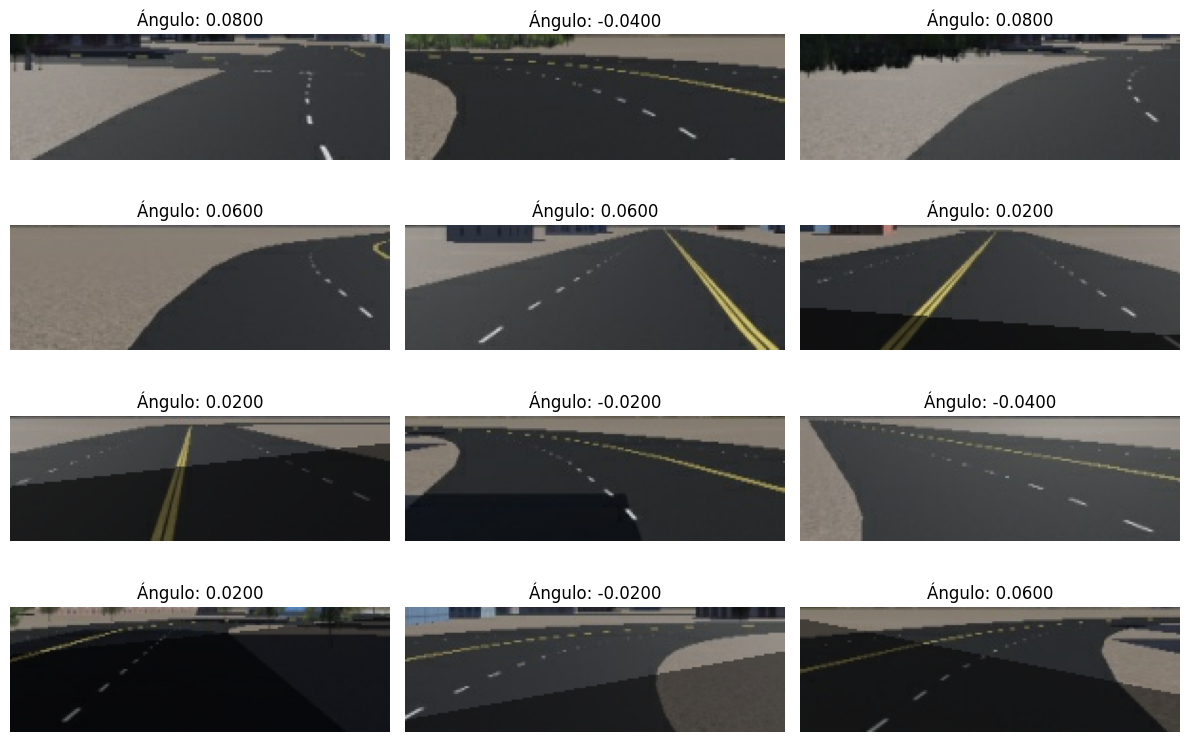

In [34]:
# A modo de ejemplo, mostramos 12 ejemplos de imágenes (originales y aumentadas)

# Tomamos un batch del dataset de entrenamiento (que incluye augmentación)
images_batch, angles_batch = next(iter(train_ds))

# Seleccionamos las primeras 12 muestras
num_examples = 12
imgs = images_batch[:num_examples]
angs = angles_batch[:num_examples]

# Graficamos las 12 muestras
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axes = axes.flatten()

for img, ang, ax in zip(imgs, angs, axes):
    ax.imshow(img)
    ax.set_title(f"Ángulo: {ang.numpy():.4f}")  
    ax.axis('off')

plt.tight_layout()
plt.show()


In [35]:

# Compilamos el modelo con optimizador, función de pérdida y métricas
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss      = 'mse',        # error cuadrático medio para regresión de ángulo
    metrics   = ['mae']       # error absoluto medio como métrica adicional
)

# Definimos callbacks para guardar el mejor modelo y detenerse temprano
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, save_format='keras'),

    # Condicion de parada temprana en caso de que el modelo no mejore por 5 epochs consecutivos
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

print("Modelo compilado y listo para entrenar")

Modelo compilado y listo para entrenar


In [36]:
# Inicamos el entrenamiento del modelo

# Iniciar el entrenamiento
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs          = 20,
        callbacks       = callbacks
    )

    print("Entrenamiento completado")

Epoch 1/20
206/206 [==============================] - 17s 32ms/step - loss: 0.3031 - mae: 0.4074 - val_loss: 0.0126 - val_mae: 0.0896
Epoch 2/20
206/206 [==============================] - 10s 32ms/step - loss: 0.0580 - mae: 0.1804 - val_loss: 0.0122 - val_mae: 0.0877
Epoch 3/20
206/206 [==============================] - 9s 37ms/step - loss: 0.0277 - mae: 0.1243 - val_loss: 0.0083 - val_mae: 0.0714
Epoch 4/20
206/206 [==============================] - 10s 39ms/step - loss: 0.0166 - mae: 0.0963 - val_loss: 0.0060 - val_mae: 0.0608
Epoch 5/20
206/206 [==============================] - 7s 29ms/step - loss: 0.0116 - mae: 0.0808 - val_loss: 0.0045 - val_mae: 0.0531
Epoch 6/20
206/206 [==============================] - 8s 34ms/step - loss: 0.0088 - mae: 0.0707 - val_loss: 0.0039 - val_mae: 0.0494
Epoch 7/20
206/206 [==============================] - 8s 33ms/step - loss: 0.0069 - mae: 0.0632 - val_loss: 0.0038 - val_mae: 0.0483
Epoch 8/20
206/206 [==============================] - 8s 31ms/step

In [37]:
# evaluar el modelo con el dataset de validación
loss, mae = model.evaluate(val_ds)

print(f"Loss: {loss:.4f}, MAE: {mae:.4f}")

69/69 [==============================] - 1s 9ms/step - loss: 0.0016 - mae: 0.0314
Loss: 0.0016, MAE: 0.0314


In [38]:
# Guardamos el modelo en formato keras con CPU
# Esto es necesario para que el modelo se pueda cargar en cualquier dispositivo
# Despues se podrá cargar el modelo en GPU basado en el modelo guardado en CPU
with tf.device('/CPU:0'):
    model.save('best_model_cpu_v5.h5', overwrite=True)
    print("Modelo guardado en formato keras con CPU")

Modelo guardado en formato keras con CPU


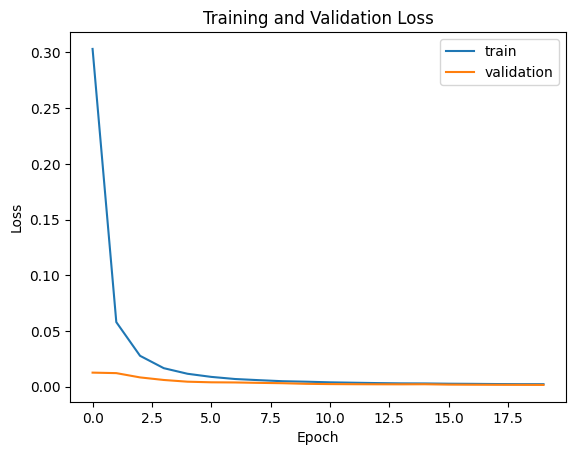

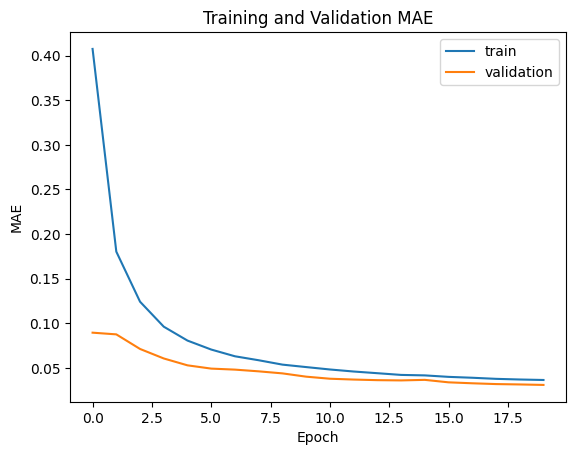

In [39]:
# Graficar Loss de entrenamiento y validación
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')  # título del gráfico
plt.ylabel('Loss')                          # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()

# Graficar MAE de entrenamiento y validación
plt.figure()
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Training and Validation MAE')   # título del gráfico
plt.ylabel('MAE')                           # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()


# Experimento 2 - Transfer Learning basado en VGG16

In [40]:
# Capa para redimensionar y rellenar imágenes
class PadAndResize(layers.Layer):
    def __init__(self, pad_to=200, resize_to=224, **kwargs):
        super().__init__(**kwargs)
        self.pad_to = pad_to
        self.resize_to = resize_to

    def call(self, inputs):
        # inputs: tensor de forma (batch, 66, 200, 3)
        shape = tf.shape(inputs)
        height = shape[1]
        # calcular cuántos píxeles agregar arriba
        pad_top = self.pad_to - height  # 200 - 66 = 134
        # pad de 134 arriba, 0 abajo, 0/0 en ancho, 0 en canales
        padded = tf.image.pad_to_bounding_box(
            inputs,
            offset_height=pad_top,
            offset_width=0,
            target_height=self.pad_to,
            target_width=self.pad_to
        )
        # redimensionar de 200×200 a resize_to×resize_to
        resized = tf.image.resize(padded, [self.resize_to, self.resize_to])
        return resized

    def get_config(self):
        config = super().get_config()
        config.update({
            "pad_to": self.pad_to,
            "resize_to": self.resize_to
        })
        return config

In [41]:
def get_model_with_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    
    return tf.keras.Sequential([
        # Pad arriba y redimensionar a 224×224
        PadAndResize(pad_to=200, resize_to=224, input_shape=(66, 200, 3)),
        
        base_model,
        # Flatten the output to feed into the dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
    
        # Second fully connected layer
        layers.Dense(100, activation='relu'),
        layers.BatchNormalization(),
    
        # Third fully connected layer
        layers.Dense(50, activation='relu'),
        layers.BatchNormalization(),
    
        # Fourth fully connected layer
        layers.Dense(10, activation='relu'),
    
        # Output layer
        layers.Dense(1)
    ])

In [43]:
# Mostramos una version del modelo basado en vgg16
model_2_vgg = get_model_with_vgg16()

# Mostramos la estructura del modelo
model_2_vgg.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pad_and_resize (PadAndResi  (None, 224, 224, 3)       0         
 ze)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 100)               2508900   
                                                                 
 batch_normalization_24 (Ba  (None, 100)               

In [44]:
# Compilamos el modelo con optimizador, función de pérdida y métricas
model_2_vgg.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss      = 'mse',        # error cuadrático medio para regresión de ángulo
    metrics   = ['mae']       # error absoluto medio como métrica adicional
)

# Definimos callbacks para guardar el mejor modelo y detenerse temprano
callbacks_2 = [
    tf.keras.callbacks.ModelCheckpoint('best_model_vgg.keras', save_best_only=True, save_format='keras'),

    # Condicion de parada temprana en caso de que el modelo no mejore por 5 epochs consecutivos
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [45]:
# Iniciamos el entrenamiento del modelo basado en vgg16

history_2 = model_2_vgg.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = 20,
    callbacks       = callbacks_2
)


Epoch 1/20
206/206 [==============================] - 85s 329ms/step - loss: 0.3219 - mae: 0.4323 - val_loss: 0.0572 - val_mae: 0.1962
Epoch 2/20
206/206 [==============================] - 58s 276ms/step - loss: 0.1364 - mae: 0.2890 - val_loss: 0.0728 - val_mae: 0.2273
Epoch 3/20
206/206 [==============================] - 49s 238ms/step - loss: 0.0899 - mae: 0.2345 - val_loss: 0.0474 - val_mae: 0.1633
Epoch 4/20
206/206 [==============================] - 51s 240ms/step - loss: 0.0659 - mae: 0.2001 - val_loss: 0.0313 - val_mae: 0.1407
Epoch 5/20
206/206 [==============================] - 58s 280ms/step - loss: 0.0493 - mae: 0.1730 - val_loss: 0.0291 - val_mae: 0.1320
Epoch 6/20
206/206 [==============================] - 51s 240ms/step - loss: 0.0394 - mae: 0.1547 - val_loss: 0.0161 - val_mae: 0.1006
Epoch 7/20
206/206 [==============================] - 51s 239ms/step - loss: 0.0311 - mae: 0.1374 - val_loss: 0.0153 - val_mae: 0.0987
Epoch 8/20
206/206 [==============================] - 5

In [46]:
# Guardamos el modelo en formato keras conå CPU
# Esto es necesario para que el modelo se pueda cargar en cualquier dispositivo
# Despues se podrá cargar el modelo en GPU basado en el modelo guardado en CPU
with tf.device('/CPU:0'):
    model_2_vgg.save('best_model_vgg_cpu.h5', overwrite=True)
    print("Modelo basado en vgg16 guardado en formato keras con CPU")

Modelo basado en vgg16 guardado en formato keras con CPU


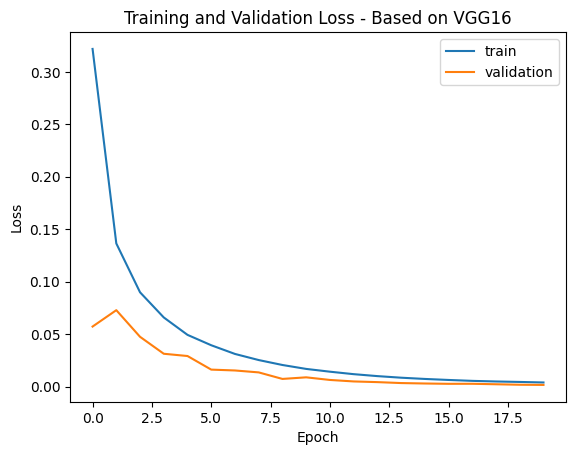

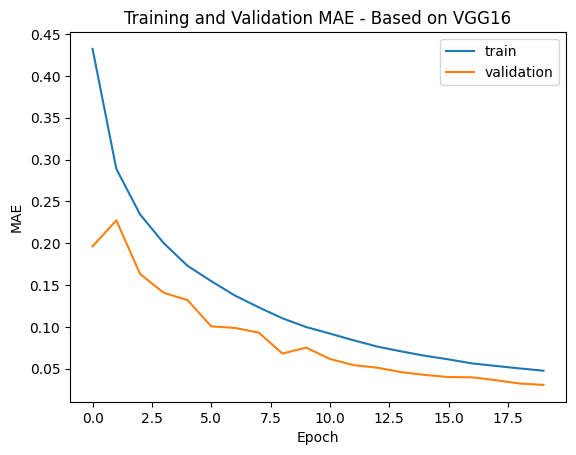

In [47]:
# Graficar Loss de entrenamiento y validación
plt.figure()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Training and Validation Loss - Based on VGG16')  # título del gráfico
plt.ylabel('Loss')                          # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()

# Graficar MAE de entrenamiento y validación
plt.figure()
plt.plot(history_2.history['mae'])
plt.plot(history_2.history['val_mae'])
plt.title('Training and Validation MAE - Based on VGG16')   # título del gráfico
plt.ylabel('MAE')                           # etiqueta eje Y
plt.xlabel('Epoch')                         # etiqueta eje X
plt.legend(['train', 'validation'])         # leyenda
plt.show()